In [1]:
import numpy as np
import gym
import seaborn as sns
import pandas as pd
import tensorflow as tf
sns.set()

***
### $Q$-learning as a Regression Problem

When we first learned about $Q$-learning, we used the Bellman equation to learn the $Q$ function:
$$
Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha \left( r_t + (1-d_t)\gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)
$$

Compare this to gradient descent for a regression problem:
$$
\theta \gets \theta - \alpha 2 \left( \hat{y} - y \right) \nabla_\theta \hat{y}
$$

These methods are essentially analogous: we update parameters about our function in a manner proportional to the difference between our prediction and the 'true' value. The difference for tabular $Q$-learning is that we essentially have a different parameter for each state-action pair. If we think about our loss function, then, we have
$$
L(\theta) = \frac{1}{2} \left( r_t + (1-d_t)\gamma \max_{a_{t+1}} \left( Q(s_{t+1}, a_{t+1}) \right) - Q(s_t, a_t) \right)^2
$$

which we can minimize using gradient descent.

### FrozenLake with Tensorflow

Before diving deep into using techniques like deep neural networks, I want to show you how we might do $Q$-learning in tensorflow using the same `FrozenLake-v0` environment from earlier.

In [2]:
class Agent:
    def __init__(self, num_states, num_actions, 
                 epsilon_i=1.0, 
                 epsilon_f=0.0, 
                 n_epsilon=0.1, 
                 alpha=0.5, 
                 gamma = 0.95,
                 hidden_layers = []
                ):
        
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon = epsilon_i
        self.n_epsilon = n_epsilon
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.Q = tf.Variable(tf.zeros((num_states, num_actions)), name="Q")
        self.optimizer = tf.keras.optimizers.SGD(alpha)

    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))
    
    def act(self, s_t):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        return np.argmax(self.Q[s_t])
    
    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        Q_next = tf.stop_gradient(np.max(self.Q[s_t_next]))
        with tf.GradientTape() as tape:
            loss = 0.5*tf.reduce_mean(r_t + (1-d_t)*self.gamma*Q_next -  self.Q[s_t, a_t])**2
        grads = tape.gradient(loss, [self.Q])
        self.optimizer.apply_gradients(zip(grads, [self.Q]))
        

In [3]:
def train(env, agent,
         T=100000):
    
    rewards = []
    episode_rewards = 0
    
    s_t = env.reset()
    
    for t in range(T):
        if t%1000 == 0:
            print(f'{100*t/T}%', end='\r')
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t, info = env.step(a_t)
        agent.update(s_t, a_t, r_t, s_t_next, d_t)
        agent.decay_epsilon(t/T)
        s_t = s_t_next
        episode_rewards += r_t
        
        if d_t:
            rewards.append(episode_rewards)
            episode_rewards = 0
            s_t = env.reset()
            
    return rewards

In [4]:
def plot(data, window=100):
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

In [5]:
env = gym.make("FrozenLake-v0")
num_states = env.observation_space.n
num_actions = env.action_space.n
agent = Agent(num_states, num_actions, alpha=0.8, gamma=0.95, epsilon_i=1.0, epsilon_f=0.0)

rewards = train(env, agent, T=100000)

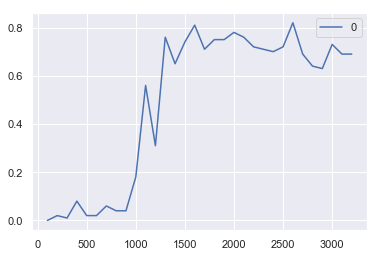

In [6]:
plot(pd.DataFrame(rewards))